In [1]:
import os
import re
import logging
import math
import random

RANDOM_SEED = 18
random.seed(RANDOM_SEED)

from typing import List, Union
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import sentence_transformers as st
import sentence_transformers.losses
from sentence_transformers.datasets import NoDuplicatesDataLoader
from sentence_transformers.readers import InputExample

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

using device: cuda


In [2]:
from bert_utils.data import *
from bert_utils.siamese import *

In [3]:
%load_ext autoreload
%autoreload 2

## TODO:

* rerank bm25 predictions with siamese net
* build pipeline for Cross-Encoder

----
* siamese net:
    * train:
        * uses MultipleNegativeRankingLoss. we provide only positive examples.
          
          for i, all the rest examples (j != i) from the batch are considered as negative examples.
          
          thus we don't need to sample negative examples explicitly.
          
          and there is no need to compute embeddings for negative examples because we reuse
          embeddings for positive examples when treating them as negatives.
          
        * NoDuplicatesDataloader is not parallel (does it impact training speed?)

    * evaluation:
        * sample negative cases randomly
        
        
* cross-encoder:
    * evaluation:
        * ideally: rerank siamese predictions -> i.e. compute classification metrices for K * |q| examples
        * for simplicity (no connection with siamese net), let's sample negative examples randomly
      
----

Notes:
* one of main bottlenecks is reading texts from disk. 
  it takes ~1.5 min to read ~11k articles (size of evaluation set with negative examples) from ssd

## data

In [4]:
def process_title(title: pd.Series):
    title = title.str.lower().str.strip()
    title = title.str.replace(r'([^\w\s])|_|-', '_', regex=True)
    return title

In [5]:
data_root_dp = '/media/rtn/Windows 10/work/univier/wiki_extract/wiki_parsed'
articles_dp = data_root_dp

filemap = pd.read_csv(os.path.join(data_root_dp, 'filepaths.csv'))
assert filemap.duplicated('filename').sum() == 0

filemap['article_id'] = list(range(filemap.shape[0]))
article_ids = set(filemap['article_id'])

print(filemap.shape)

(223619, 4)


In [6]:
get_article_text(get_article_path('poetry', filemap))

'Poetry is a type of art form and a type of literature. Poetry uses the qualities of words, in different ways, to be artistic. Poetry can be as short as a few words, or as long as a book. A poem as short as one line is called a monostich. A poem that is as long as a book is an epic. There are many "poetic forms" (forms of poetry). Some of forms are: Sonnet, Haiku, Ballad, Stev, Prose poem, Ode, Free verse, Blank verse, thematic, limerick and nursery rhymes. Poetry can be used to describe (comparing, talking about, or expressing emotion) many things. It can make sense or be nonsense, it can rhyme or not. It can have many shapes and sizes; it can be serious or funny. "To say something poetically" means to give information in an artistic way. A more modern approach is digital poetry. Computers and webtechnology is used to express poetry and make it interactive. So called interdisciplinary poetry (wich means combination of different forms of poetry) are made possible by linking the poetic 

In [7]:
labels_test = pd.read_csv('data/queries.tsv', sep='\t', header=None)
labels_test.columns = ['query', 'title']
labels_test['title'] = process_title(labels_test['title'])

print(labels_test.shape)
labels_test.head(3)

(200, 2)


,query,title
0,animals that have shells and live in water,shell__zoology_
1,how many different types of scorpions are there,scorpion
2,describe the structure of a scientific name fo...,binomial_nomenclature


In [8]:
labels_train_raw = pd.read_csv('data/train.tsv', sep='\t', header=None)
labels_train_raw.columns = ['query', 'title']
labels_train_raw['title'] = process_title(labels_train_raw['title'])

print(labels_train_raw.shape)
labels_train_raw.head(3)

(50000, 2)


,query,title
0,where does the most metabolic activity in the ...,cytoplasm
1,what kind of dog played in turner and hooch,dogue_de_bordeaux
2,when is there gonna be an eclipse 2017,solar_eclipse_of_august_21__2017


In [9]:
filemap.head()

,filename,path,html_path,article_id
0,000_emergency,/media/rtn/Windows 10/work/univier/wiki_extrac...,/media/rtn/Windows 10/work/univier/wiki_extrac...,0
1,0s_bc,/media/rtn/Windows 10/work/univier/wiki_extrac...,/media/rtn/Windows 10/work/univier/wiki_extrac...,1
2,0_0_0,/media/rtn/Windows 10/work/univier/wiki_extrac...,/media/rtn/Windows 10/work/univier/wiki_extrac...,2
3,0_4_0,/media/rtn/Windows 10/work/univier/wiki_extrac...,/media/rtn/Windows 10/work/univier/wiki_extrac...,3
4,0_6_0,/media/rtn/Windows 10/work/univier/wiki_extrac...,/media/rtn/Windows 10/work/univier/wiki_extrac...,4


### filter train, test samples

In [10]:
two_sets_stats(filemap['filename'], labels_train_raw['title'])

init shapes: (223619, 50000)
unique elements: (223619, 16731)
s1 & s2: 15430
s1 ^ s2: 209490
s1 - s2: 208189
s2 - s1: 1301


In [11]:
two_sets_stats(filemap['filename'], labels_test['title'])

init shapes: (223619, 200)
unique elements: (223619, 142)
s1 & s2: 137
s1 ^ s2: 223487
s1 - s2: 223482
s2 - s1: 5


In [12]:
# labels_train_raw = labels_train_raw[labels_train_raw['title'].isin(filemap['filename'])]
# labels_test = labels_test[labels_test['title'].isin(filemap['filename'])]

labels_train_raw = labels_train_raw.merge(
    filemap[['filename', 'article_id']], 
    left_on='title', right_on='filename', how='inner').drop(columns='filename')

labels_test = labels_test.merge(
    filemap[['filename', 'article_id']], 
    left_on='title', right_on='filename', how='inner').drop(columns='filename')

print(labels_train_raw.shape[0])
print(labels_test.shape[0])

45260
194


In [13]:
labels_train_raw.head(2)

,query,title,article_id
0,where does the most metabolic activity in the ...,cytoplasm,52039
1,what is the structure that contains ions subst...,cytoplasm,52039


In [14]:
labels_test.head(2)

,query,title,article_id
0,animals that have shells and live in water,shell__zoology_,180649
1,how many different types of scorpions are there,scorpion,177775


## siamese model

### prepare data

In [15]:
assert labels_train_raw['query'].duplicated().sum() == 0  # else we should split into (train, val) by queries

labels_train, labels_val = train_test_split(
    labels_train_raw, random_state=RANDOM_SEED, test_size=0.15, shuffle=True)

print(labels_train.shape)
print(labels_val.shape)

(38471, 3)
(6789, 3)


In [16]:
val_dataset = add_negative_samples_to_val_set(
    labels_val=labels_val, val_neg_to_pos_factor=1, 
    all_article_ids=article_ids, filemap=filemap, 
)
print(val_dataset.shape)

(13578, 4)


In [17]:
val_dataset.head(2)

,query,title,article_id,label
0,the governor general who annexed sindh in brit...,charles_james_napier,40657,1
1,where does the thirteen reasons why take place,13_reasons_why,635,1


In [102]:
val_dataset['label'].value_counts()

1    6789
0    6789
Name: label, dtype: int64

In [18]:
# load all aricles for val_dataset beforehand
val_dataset_articles = []
for t in tqdm(val_dataset['title']):
    val_dataset_articles.append(get_article_text(get_article_path(t, filemap)))

  0%|          | 0/13578 [00:00<?, ?it/s]

In [19]:
print(labels_train_raw['title'].nunique())
print(labels_train['title'].nunique())
print(val_dataset['title'].nunique())

15430
14136
11162


In [20]:
train_dataset = WikiQADataset(labels_train, filemap=filemap)

In [21]:
train_dataset[2].texts

['how do they draw teams for the world cup',
 'The knockout stage of the 2018 FIFA World Cup is the second stage of the competition, just after the group stage. It began on 30 June with the round of 16 and ended on 15 July with the final match, held at the Luzhniki Stadium in Moscow. The top two teams from each group (16 in total) would advance to the knockout stage to compete in a single-elimination. In the knockout stage, if a match is level at the end of 90 minutes of normal playing time, extra time would be played (two periods of 15 minutes each), where each team is allowed to make a fourth substitution. If still tied after extra time, the match would be decided by a penalty shoot-out to determine the winners. A third place play-off will also be played between the two losing teams of the semi-finals. The top two placed teams from each of the eight groups will qualify for the knockout stage.']

### train siamese model

In [22]:
# TODO: has max_seq_length: 128. can change to other model
model = st.SentenceTransformer('distilbert-base-nli-mean-tokens')
model.to(device);

In [23]:
num_epochs = 5
train_batch_size = 16
val_batch_size = 64
train_dl = CustomNoDuplicatesDataLoader(train_dataset, batch_size=train_batch_size)
warmup_steps = math.ceil(len(train_dl) * num_epochs * 0.1)
eval_steps = int(len(train_dl) * 0.2)

out_root_dp = '/media/rtn/data/fajly2/nn/bert'
checkpoints_dp = os.path.join(out_root_dp, 'siam', 'checkpoints')
output_dp = os.path.join(out_root_dp, 'siam', 'output')

print(f"num_epochs: {num_epochs}")
print(f'train_batch_size: {train_batch_size}')
print(f'val_batch_size: {val_batch_size}')
print(f"warmup steps: {warmup_steps}")
print(f'len(train_dl): {len(train_dl)}')
print(f'eval_steps: {eval_steps}')

print(f'checkpoints_dp:\t"{checkpoints_dp}"')
print(f'output_dp:\t"{output_dp}"')

num_epochs: 5
train_batch_size: 16
val_batch_size: 64
warmup steps: 1202
len(train_dl): 2404
eval_steps: 480
checkpoints_dp:	"/media/rtn/data/fajly2/nn/bert/siam/checkpoints"
output_dp:	"/media/rtn/data/fajly2/nn/bert/siam/output"


In [24]:
train_loss = st.losses.MultipleNegativesRankingLoss(model=model)

In [25]:
val_evaluator = CustomBinaryClassificationEvaluator(
    sentences1=val_dataset['query'].tolist(),
    sentences2=val_dataset_articles,
    labels=val_dataset['label'].tolist(),
    batch_size=val_batch_size
)

In [26]:
model.fit(
    train_objectives=[(train_dl, train_loss)],
    epochs=num_epochs,
    evaluator=val_evaluator,
    evaluation_steps=eval_steps,
    
    checkpoint_path=checkpoints_dp,
    checkpoint_save_steps=eval_steps,
    output_path=output_dp,
    save_best_model=True,
    
    optimizer_params={'lr': 2e-5},
    weight_decay= 0.01,
    scheduler='WarmupLinear',
    warmup_steps=warmup_steps,
    use_amp=False,
    
#     steps_per_epoch=300,  # for debug
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2404 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2404 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2404 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2404 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2404 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

Batches:   0%|          | 0/277 [00:00<?, ?it/s]

### read val metrics

In [95]:
val_metrics = pd.read_csv(os.path.join(output_dp, 'eval', 'validation_evaluator_results.csv'))

train_dl_len = 2404
val_metrics.rename(columns={'steps': 'steps_epoch_raw'}, inplace=True)
val_metrics['steps_epoch'] = val_metrics['steps_epoch_raw'].where(
    val_metrics['steps_epoch_raw'] != -1, train_dl_len)
val_metrics['steps'] = (val_metrics['epoch'] * train_dl_len) + val_metrics['steps_epoch']
val_metrics

,epoch,steps_epoch_raw,f1_threshold,f1,precision,recall,accuracy,ap,steps_epoch,steps
0,0,480,0.381776,0.957860,0.966697,0.949183,0.958241,0.991282,480,480
1,0,960,0.336423,0.970414,0.974595,0.966269,0.970541,0.995059,960,960
2,0,1440,0.314055,0.971833,0.972981,0.970688,0.971866,0.995643,1440,1440
3,0,1920,0.296106,0.974109,0.975621,0.972603,0.974149,0.995784,1920,1920
4,0,2400,0.306701,0.974021,0.978875,0.969215,0.974149,0.996078,2400,2400
5,0,-1,0.305364,0.973717,0.978863,0.968626,0.973855,0.996044,2404,2404
6,1,480,0.301013,0.975646,0.980655,0.970688,0.975770,0.996214,480,2884
7,1,960,0.275420,0.975368,0.979643,0.971130,0.975475,0.996194,960,3364
8,1,1440,0.289259,0.977515,0.981726,0.973339,0.977611,0.996546,1440,3844
9,1,1920,0.267868,0.976799,0.976871,0.976727,0.976801,0.996304,1920,4324


In [96]:
best_val_stats = val_metrics.loc[[val_metrics['f1'].idxmax()]]
best_val_stats

,epoch,steps_epoch_raw,f1_threshold,f1,precision,recall,accuracy,ap,steps_epoch,steps
17,2,-1,0.279577,0.97866,0.984643,0.97275,0.978789,0.996402,2404,7212


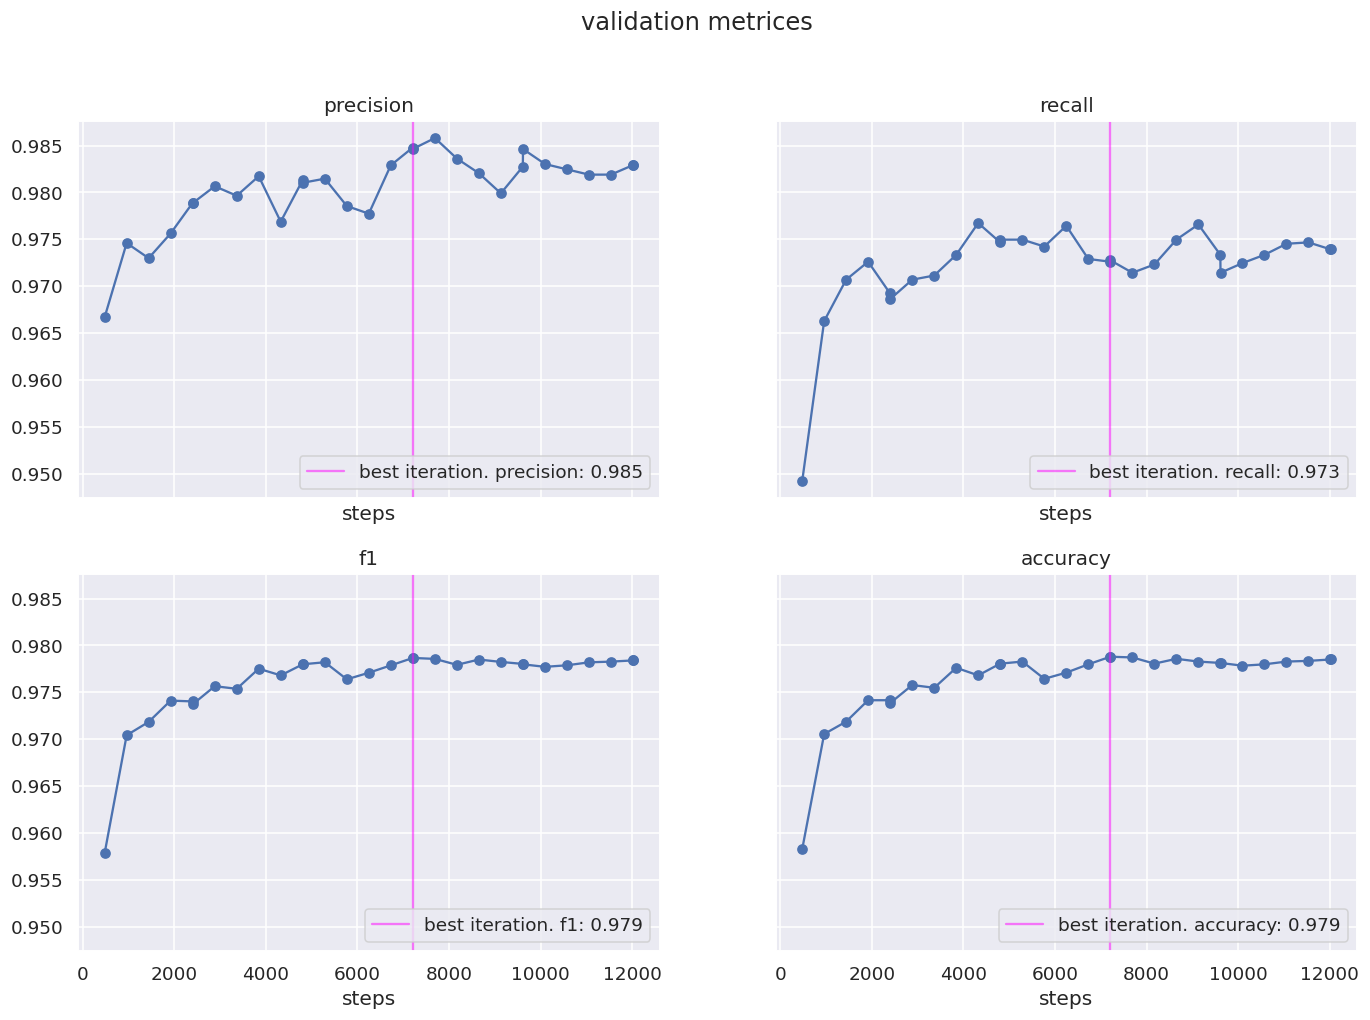

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True, dpi=110)
cols = ['precision', 'recall', 'f1', 'accuracy']
for a, col in zip(ax.flatten(), cols):
    a.plot(val_metrics['steps'], val_metrics[col], 'o-');
    best_iteration_val = best_val_stats[col].iloc[0]
    a.axvline(best_val_stats['steps'].iloc[0], c='magenta', alpha=0.5, 
              label=f'best iteration. {col}: {best_iteration_val :.3f}')
    a.legend(loc='lower right');
    a.set_title(col)
    a.set_xlabel('steps');
fig.suptitle('validation metrices');

### predict with best model
* sbert has 2 different counters: `training_steps` and `global_step`.
  they are counted differntly and are used for model evaluation and save respectively.
  that's why val metrics were reported for model states different than those saved to disk.
  
  for simplicity load best model here not from checkpoints but from dir with best model. 
  
  best model was selected by `f1` score in evaluator.

In [101]:
print(f'loading from: "{output_dp}"')
model = st.SentenceTransformer(output_dp)

loading from: "/media/rtn/data/fajly2/nn/bert/siam/output"


## debug